In [55]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import random
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation
from matplotlib import path
import time
import cv2
from glob import glob
import os
import shutil
from queue import PriorityQueue 
from queue import LifoQueue
%matplotlib inline

<h3><b>The Environment</b></h3>
We created a 5 x 5 Environment for the RRT experiment and planted some obstacles using the Convex Hull function from scipy.spatial. We planted two trapezoidal obstacles in the top and bottom and similar trapezoidal obstacles on the right side. The end point is put in the bottom right corner.

In [57]:
def draw_map(obstacles):
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch(Polygon(obstacles[k]))

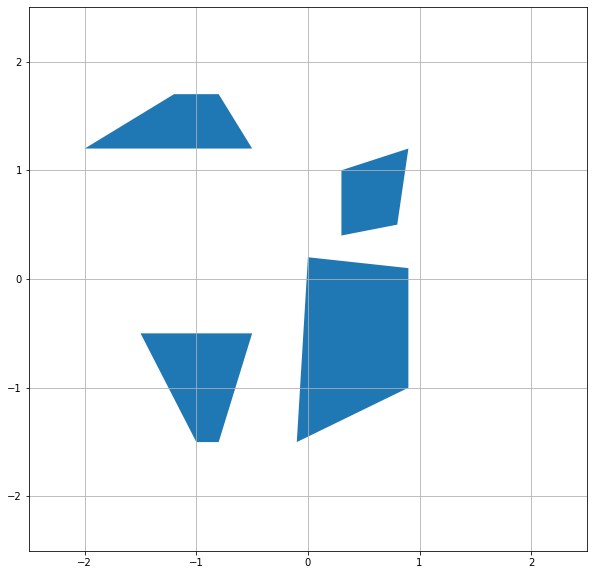

In [58]:
w = 0.2
#Creating arbritarily shaped obstacles
obstacles = [
              np.array([[0.3,0.4], [0.8,0.5], [0.9,1.2], [0.3,1.0]]),
              np.array([[0,0.2],[0.9,0.1],[0.9,-1.0],[-0.1,-1.5]]),
              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]
draw_map(obstacles)

<h2><u>THE ALGORITHM</u></h2>

<h4>The Robot</h4>
For the RRT algorithm, holonomic case, we are using a Differential Drive robot for our experiments that can turn in any direction as and when required.<br>
The Kinematics for the robot are-<br>
If we consider $x_{icc}$ and $y_{icc}$ as the center of the system, then the left and right wheels velocity, which are coupled, will be then coupled together by an angle $\theta$, which the Center of Mass(CoM) makes with the normal, so the subsequent Kinematic equations will be-<br>
<center>$v_x$ = $v_{cm}$*cos($\theta$(t))</center>
<center>$v_y$ = $v_{cm}$*sin($\theta$(t))</center>
Here, $v_{cm}$ denotes the velocity of the center of Mass and the subsequent x and y distances can be obtained by integrating the above equations wrt time, while $\theta(t)$ can be obtained by integrating $\omega$ w.r.t time.

In [59]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [60]:
def closestNode(rrt, p):
    #Finds the closest node in the tree to the generated point.
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0]) ** 2 + (p[1] - node.p[1]) ** 2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [61]:
def isCollisionFreeVertex(obstacles, xy):
    #Checking if the point has spawned in a valid location
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            return collFree

    return collFree

In [62]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    #Checking if the line joining closest_vert and xy is free of obstacles or not
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0, 1, M)
    for i in range(1 ,M-1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

In [63]:
def start_node(source):
    #Creates the source of class Node
    start_node = Node()
    start_node.p = source
    start_node.i = 0
    start_node.iPrev = 0 
    return start_node

In [64]:
def get_point(goal):
    #Generates a random point in the grid space
#     rnd = random.random()
#     if rnd < 0.01:
#         #For good convergence, generating a point close to the goal
#         point = np.array([goal[0] + rnd, goal[0] + rnd])
#     elif rnd >= 0.01 and rnd < 0.02:
#         point = np.array([goal[0] + rnd, goal[0] - rnd]) 
#     elif rnd >= 0.02 and rnd < 0.03:
#         point = np.array([goal[0] - rnd, goal[0] - rnd]) 
#     elif rnd >= 0.03 and rnd < 0.04:
#         point = np.array([goal[0] - rnd, goal[0] + rnd]) 
#     else:
    point = np.array([random.random() * 5 - 2.5, random.random() * 5 - 2.5])    
    return point

In [65]:
def get_closest_node(tree, point, d = 0.2):
    #Get's a 
    closest_node = closestNode(tree, point)
    new_node = Node()
    new_node.p = closest_node.p + d * (point - closest_node.p)
    new_node.i = len(tree)
    new_node.iPrev = closest_node.i
    return new_node

In [66]:
def get_points_non_holo(exploree, V, dt):
    #Generates a random point in the grid space
    dalpha = np.arange(0,360,1)
    random.shuffle(dalpha)
    alpha_arr = np.array(dalpha[0:10])
    points = []
    for angle in alpha_arr:
        if angle == 90:
            print(angle, exploree)
        if angle != 90:
            Vx = np.array(cos(radians(angle)) * V)
            Vy = np.array(sin(radians(angle)) * V)
            points.append(np.array([exploree[0] + Vx * dt, exploree[1] + Vy * dt]))
    points = np.asarray(points)
    return points

In [67]:
def closest_node_stack(input_stack, goal):
    minD = 10e4
    #need to modify to 
    stack = LifoQueue()
    closest = np.array([666999, 999666])
    print(input_stack.qsize())
    for ele in range(input_stack.qsize()):
        head = input_stack.get()
        dist = head[0]
        pp   = head[1]
        if dist < minD:
            if minD == 10e4:
                pass
            else:
                stack.put((minD, closest))
            minD = dist
            closest = pp
        else:
            stack.put((dist, pp))
    return stack, closest

In [68]:
def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''

    image_files = sorted(glob(input_path))
    final = len(image_files)
    #for i in range(20):
    #    image_files.append(image_files[final - 1])
        
    frames = [] 
    for f in image_files: 
        frame = cv2.imread(f)
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True
#frames_to_video("./plots_temp/*.png", "./capture_temp.mp4", 24)

1
2
3
4
5
6
7
90 [0.22208723 0.22271724]
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
90 [0.01075525 0.20245563]
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
90 [-0.5905712 -0.3689855]
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
90 [-0.89222509 -0.49060205]
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
90 [-1.40124803 -0.49427872]
135
136
137
138
139
140
141
142
143
144
145
90 [-1.52742532 -0.56121573]
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
90 [-1.70743115 -0.99148142]
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
90 [-1.80327929 -1.39372708]
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
90 [-1.90727258 -1.65945529]
208
209
210
90 [-1.923014

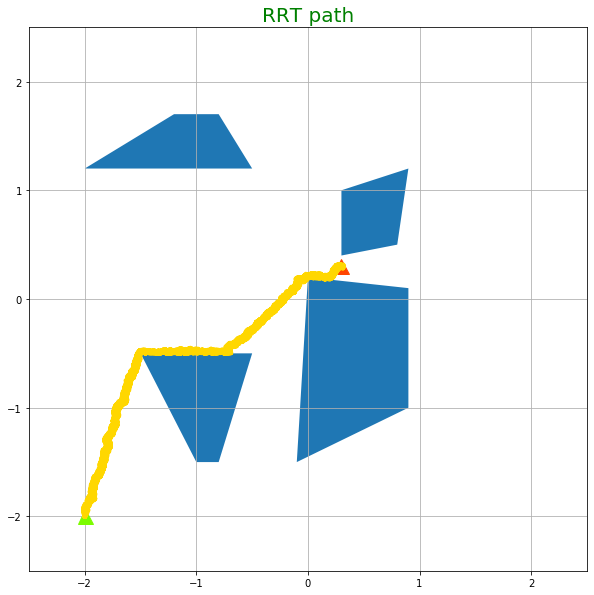

In [94]:
if __name__ == "__main__":
    maxiters  = 2000
    nearGoal = False 
    minDistGoal = 0.05
    d = 0.1
    dt = 0.2
    if os.path.isdir("./plots_temp"):
        shutil.rmtree("./plots_temp")
    os.mkdir("./plots_temp")
    
    draw_map(obstacles)
    stack = LifoQueue()
    xy_start = np.array([0.3, 0.3]); plt.plot(xy_start[0],xy_start[1],'^',color = 'orangered', markersize = 15)
    xy_goal =  np.array([-2.0, -2.0]);  plt.plot(xy_goal[0], xy_goal[1], '^',color = 'lawngreen',markersize = 15)

    rrt = []
    rrt.append(start_node(xy_start))

    #pq = PriorityQueue()
    start_time = time.time()
    iters = 0
    to_explore = Node()
    to_explore.p = xy_start
    to_explore.i = 0
    to_explore.iPrev = 0
    to_explore_update = Node()
    while not nearGoal and iters < maxiters:
        iters += 1
        #print(to_explore.p)
        print(iters)
        sampled_trajectories = get_points_non_holo(to_explore.p, d, dt)
        minDistFromGoal = 10e4
        flag = True
        for t in sampled_trajectories:
            if isCollisionFreeEdge(obstacles, to_explore.p, t) and t[0] < 2.5 and t[0] > -2.5 and t[1] < 2.5 and t[1] > -2.5:
                dist_from_goal = norm(xy_goal - t)
                flag = False
                to_node = Node()
                to_node.p = t
                to_node.iPrev = to_explore.i
                to_node.i = to_explore.i + 1
                if dist_from_goal < minDistFromGoal:
                    minDistFromGoal = dist_from_goal
                    to_explore_update = to_node
                rrt.append(to_node)
                if minDistFromGoal < minDistGoal:
                    goal_node = Node()
                    goal_node.p = xy_goal
                    goal_node.i = len(rrt)
                    goal_node.iPrev = to_node.i
                    if isCollisionFreeEdge(obstacles, to_node.p, goal_node.p):
                        rrt.append(goal_node)
                        #P = [goal_node.p]
                        P = []
                    else: 
                        P = []
                    nearGoal = True
            elif flag:
                to_explore_update = rrt[len(rrt) - 1]
          
            plt.plot(to_node.p[0], to_node.p[1], 'o',color = 'blue', markersize = 0.6)
            plt.plot([to_explore.p[0], to_node.p[0]], [to_explore.p[1], to_node.p[1]], color = 'aqua', linewidth = 0.7)
        to_explore = to_explore_update
        
       

    plt.title("RRT path", fontsize = 20, color = 'green')
    i = len(rrt) - 1
    print(i)
   
    for j in range(0,i):
        P.append(rrt[j].p)
     
    P = np.array(P)
    print(P)
    print('Number of nodes: ', len(rrt))
    print(f"Number of nodes on the RRT path: {P.shape[0]}")
    plt.plot(P[:,0],P[:,1], color = 'gold', linewidth = 5 )


Some graphs of the equations work in progress are-
<h3>The Starting of the Non-holonomic RRT and Encounter the first obstacle</h3>
<img src = "Non-holo1.jpeg">

<h3>The Robot continues its path towards goal by skating the obstacle</h3>
<img src = "Non-holo2.jpeg">

<h3>The Robot explores straight towards Goal</h3>
<img src = "Non-holo3.jpeg">

<h3>The Robot skates the second Obstacle</h3>
<img src = "Non-holo4.jpeg">